In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from collections import defaultdict
from scipy.linalg import svd
import seaborn as sns
import multiprocessing
from functools import partial
import ruamel.yaml
from causal_optoconnectics.graphics import regplot, scatterplot, probplot
from causal_optoconnectics.tools import min_error
%matplotlib inline
import sys
sys.path.append('../scripts')
from analyse_sweep import reduce_sum, compute_connectivity_from_sum 

sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.figsize': (6,5), 'figure.dpi': 150})

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_1/')

In [4]:
data_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'],axis=1)

In [5]:
# data_df.sigma = data_df.apply(lambda x: 0.5 if x.path.endswith('05') else x.sigma, 1)

In [6]:
# data_df.loc[:,'error_diff_did'] = data_df.error_beta_ols_did - data_df.error_beta_iv_did

/tmp/ipykernel_1783146/2046835696.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())


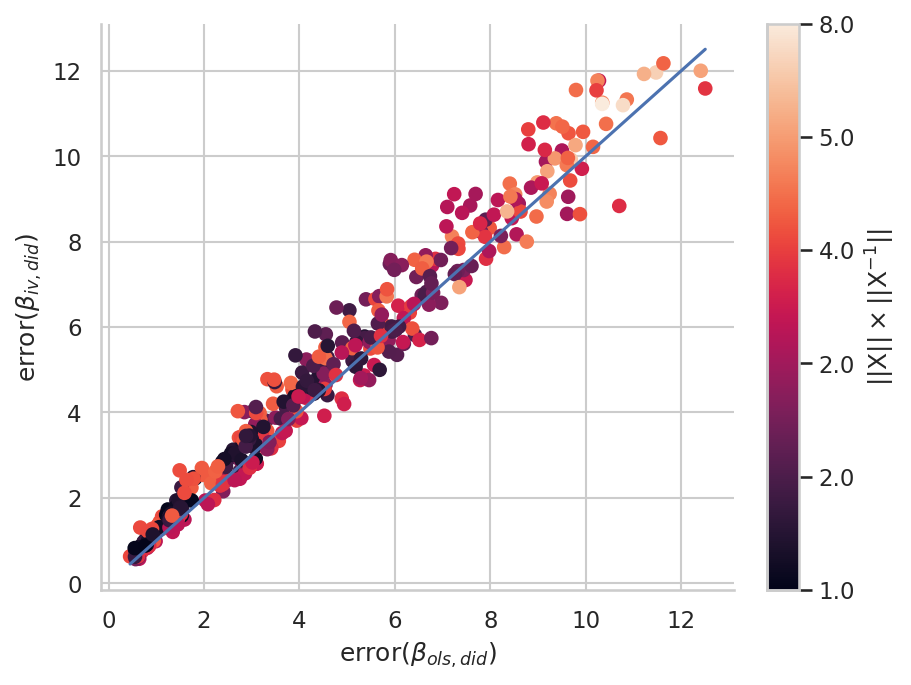

In [7]:
import matplotlib
var1 = 'error_beta_ols_did'
var2 = 'error_beta_iv_did'
fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(6,5), dpi=150)
mnorm = matplotlib.colors.LogNorm()
xmin, xmax = min(data_df[var1].min(), data_df[var2].min()), max(data_df[var1].max(), data_df[var2].max())
sc = ax.scatter(data_df[var1], data_df[var2], c=mnorm(data_df.x_condition))
ax.plot([xmin, xmax], [xmin, xmax])
ax.set_xlabel(fr'$\mathrm{{error}}(\beta_{{{",".join(var1.split("_")[2:])}}})$')
ax.set_ylabel(fr'$\mathrm{{error}}(\beta_{{{",".join(var2.split("_")[2:])}}})$')
cbar = plt.colorbar(sc, cax=cax)
cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())
cbar.ax.set_ylabel(r'$||\mathrm{X}|| \times ||\mathrm{X}^{-1}||$')
sns.despine()

In [8]:
sub_df = data_df.query('n_neurons==50')

<AxesSubplot:xlabel='stim_strength', ylabel='sigma'>

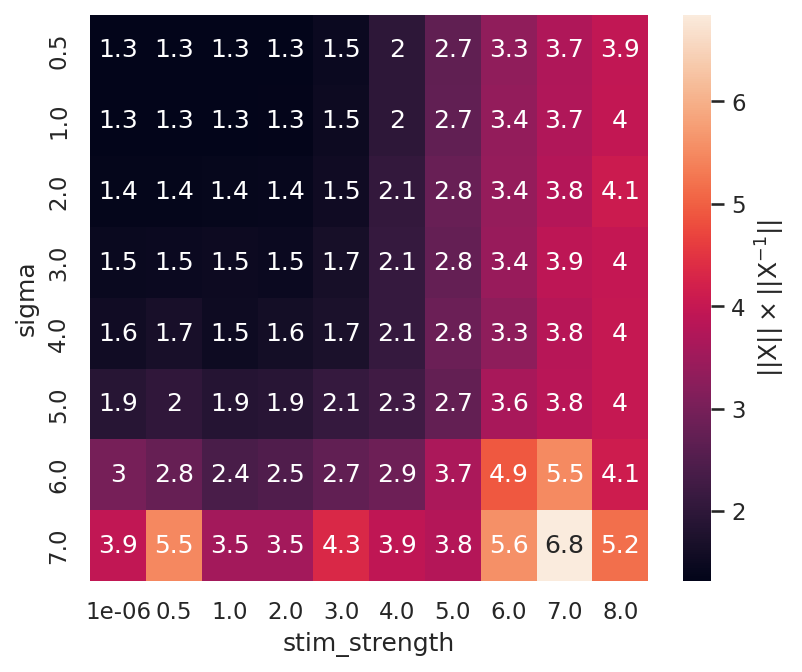

In [9]:
sns.heatmap(
    sub_df.pivot('sigma', 'stim_strength', 'x_condition'), 
    annot=sub_df.pivot('sigma', 'stim_strength', 'x_condition'),
    cbar_kws={'label': r'$||\mathrm{X}|| \times ||\mathrm{X}^{-1}||$'}
)

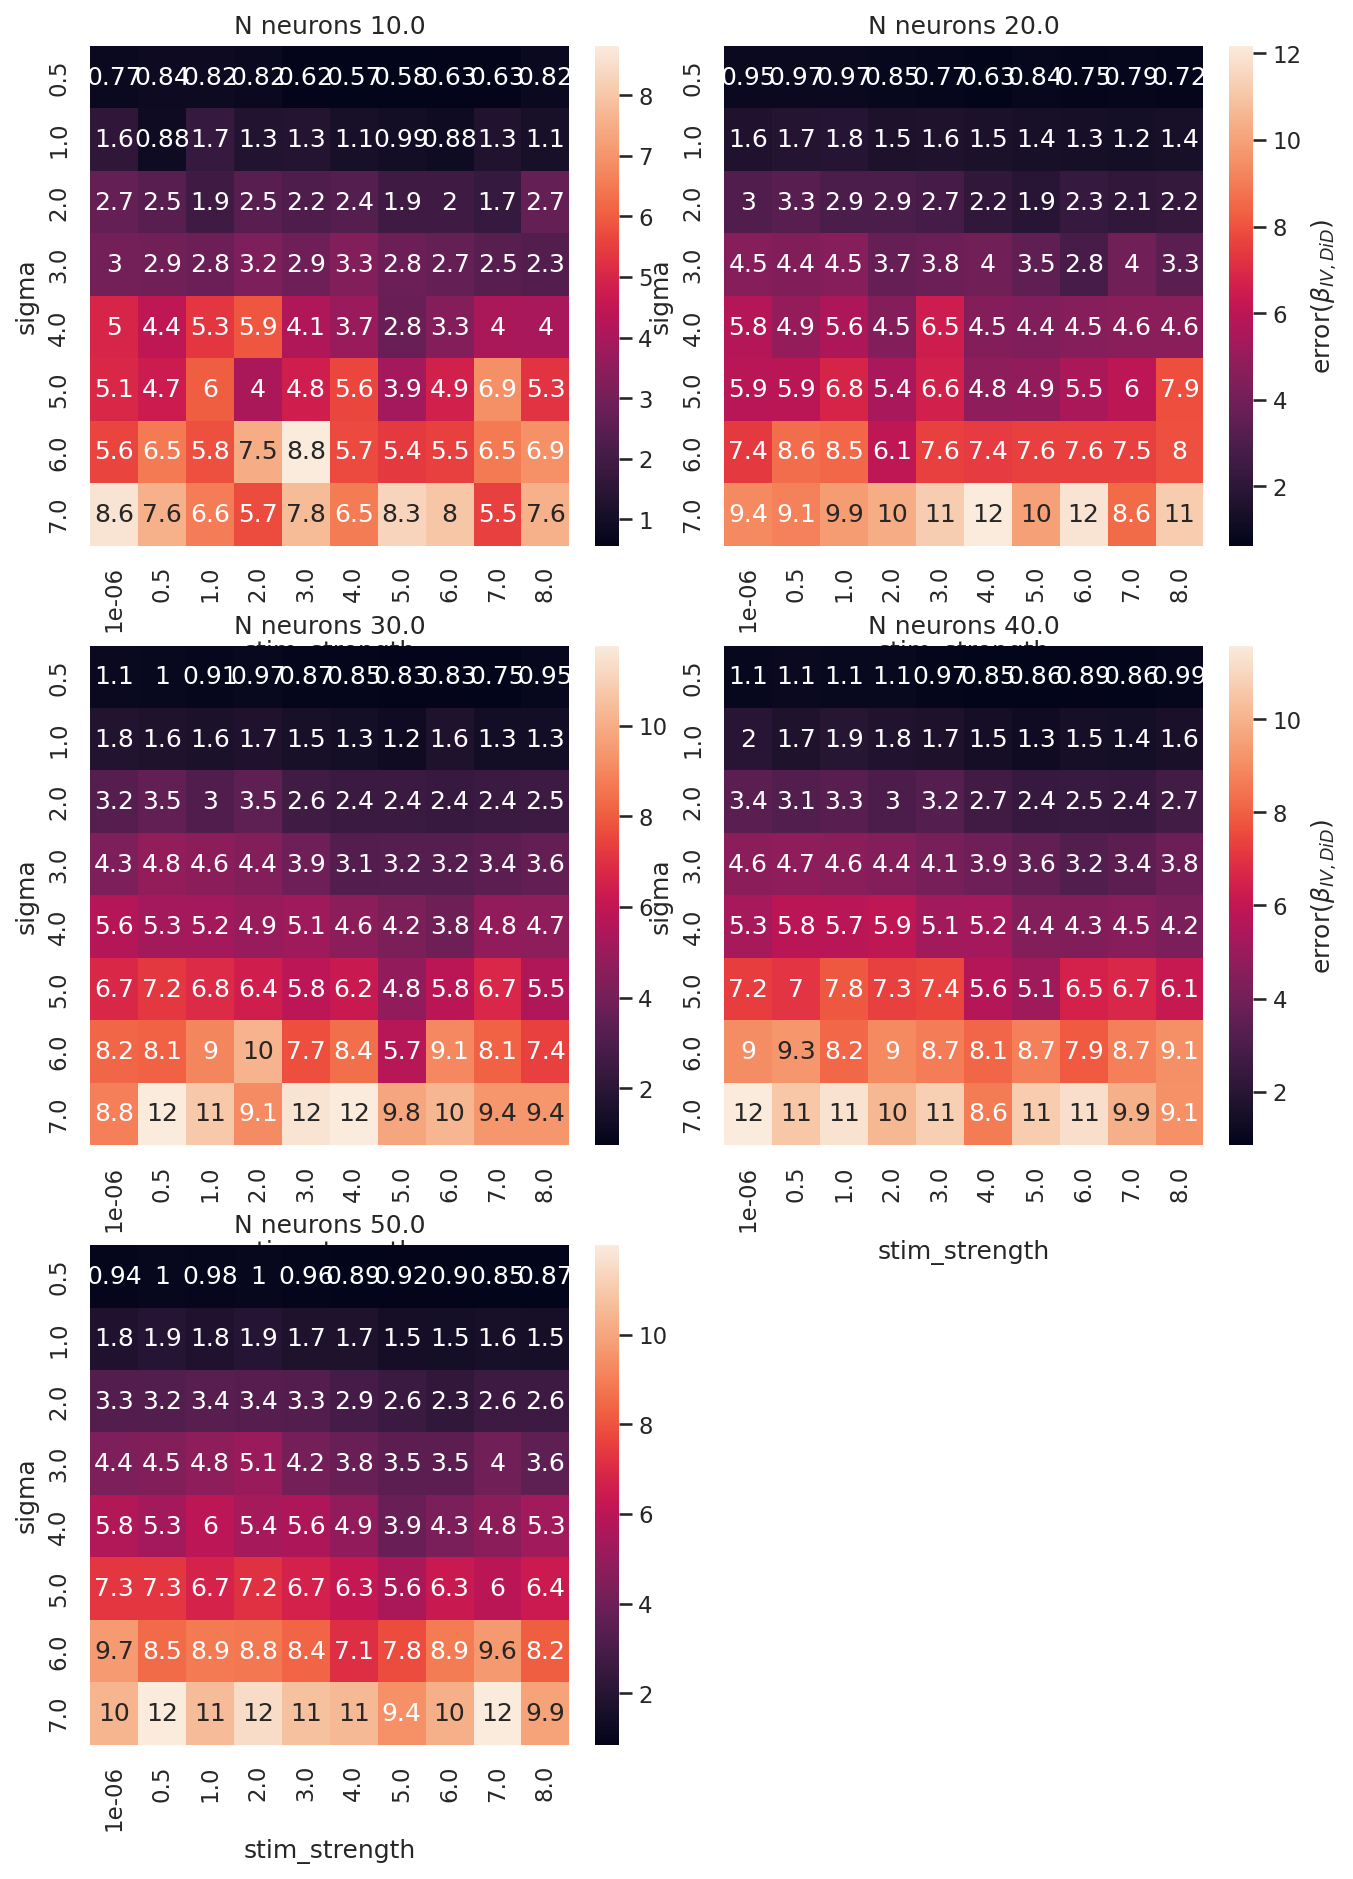

In [10]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(3, 2, figure=fig)
for i, (n_neurons, df) in enumerate(data_df.groupby('n_neurons')):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[i], width_ratios=[1,0.05], wspace=0.1)
    ax = fig.add_subplot(gs00[0,0])
    cax = fig.add_subplot(gs00[0,1])
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'error_beta_iv_did'), 
        annot=df.pivot('sigma', 'stim_strength', 'error_beta_iv_did'), 
        cbar_ax=cax, ax=ax, cbar_kws={'label': r'$\mathrm{error}(\beta_{IV,DiD})$' if i%2!=0 else ''})
    ax.set_title(f'N neurons {n_neurons}')

In [11]:
def violin_compare(var1, var2, x='stim_strength'):
    plt.figure()
    v1 = data_df.loc[:, [x, var1]].rename(columns={var1: 'Error'})
    key = lambda x: ','.join(x.split('_')[2:])
    v1[''] = key(var1)
    v2 = data_df.loc[:, [x, var2]].rename(columns={var2: 'Error'})
    v2[''] = key(var2)
    viodf = pd.concat([v1,v2])
    sns.violinplot(
        data=viodf, x=x, y='Error', hue='', split=True, inner="quart", linewidth=1,
                   palette={key(var1): "b", key(var2): ".85"}, cut=0,
    )
    sns.despine()
    plt.legend(frameon=False, loc=1)

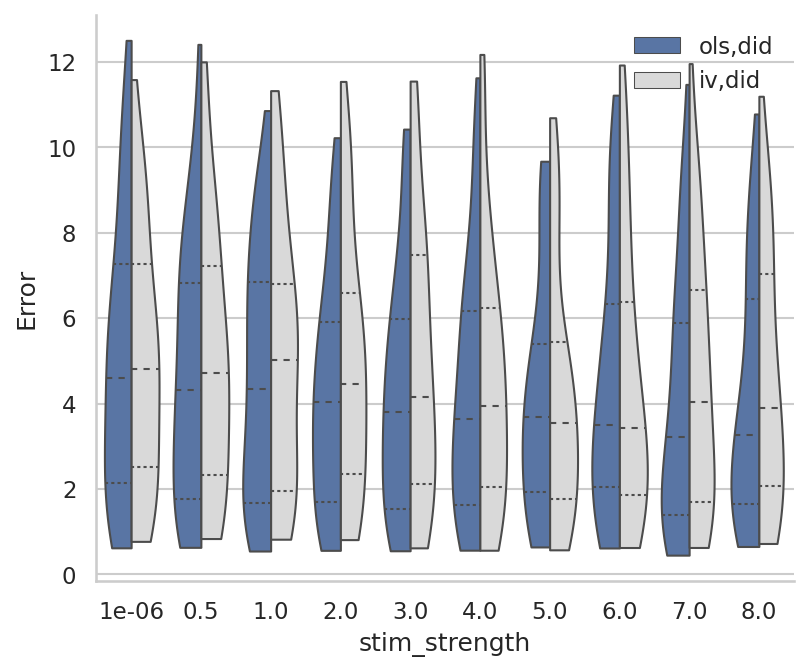

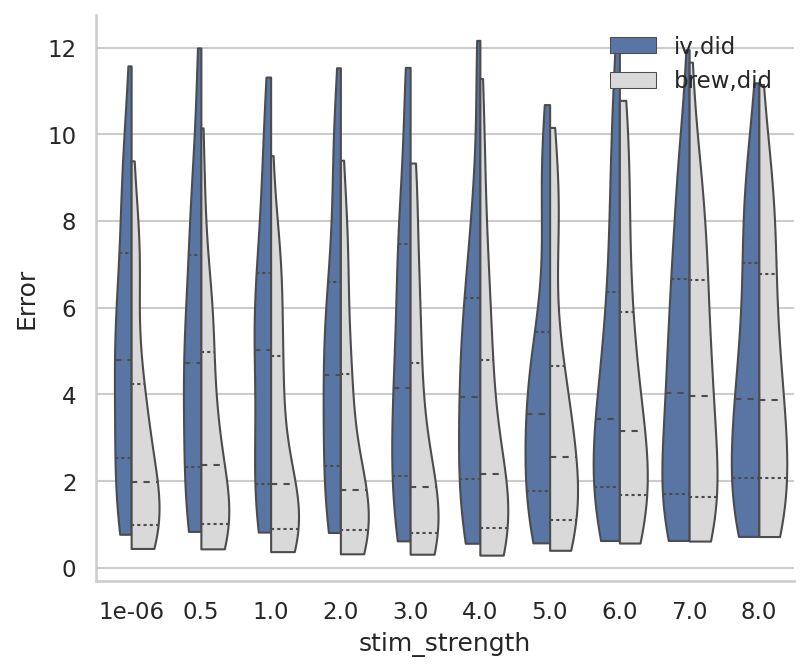

In [12]:
violin_compare('error_beta_ols_did', 'error_beta_iv_did')
violin_compare('error_beta_iv_did', 'error_beta_brew_did')
# violin_compare('error_beta_iv_did', 'error_beta_ols_did')

In [13]:
def violin_compare_all(var_list):
    plt.figure()
    key = lambda x: ','.join(x.split('_')[2:])
    viodf = pd.DataFrame()
    for var in var_list:
        v = pd.DataFrame()
        v['Error'] = data_df.loc[:, var]
        v[''] = key(var)
        viodf = pd.concat([viodf,v])
    sns.violinplot(
        data=viodf, x='', y='Error', inner="quart", linewidth=1, cut=0,
    )
    sns.despine()

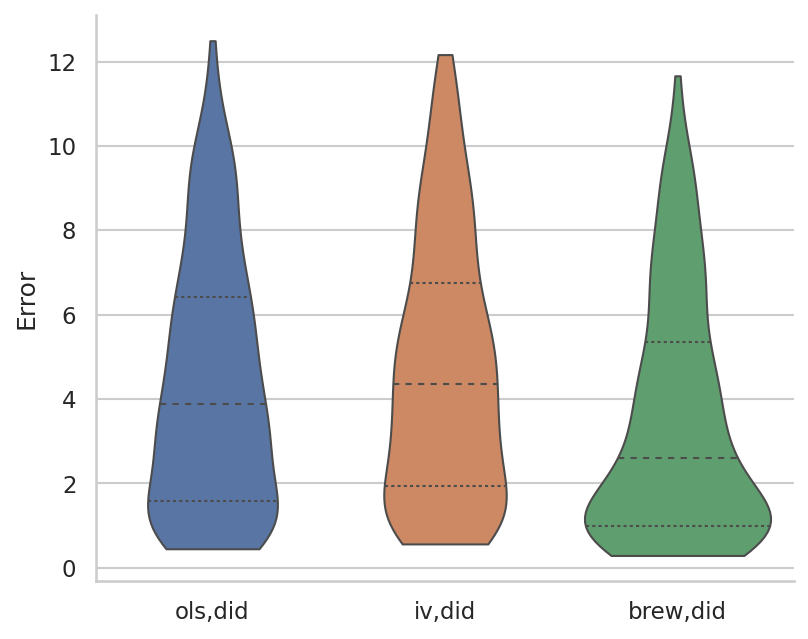

In [14]:
violin_compare_all(['error_beta_ols_did', 'error_beta_iv_did', 'error_beta_brew_did'])

# Compare error between OLS and IV

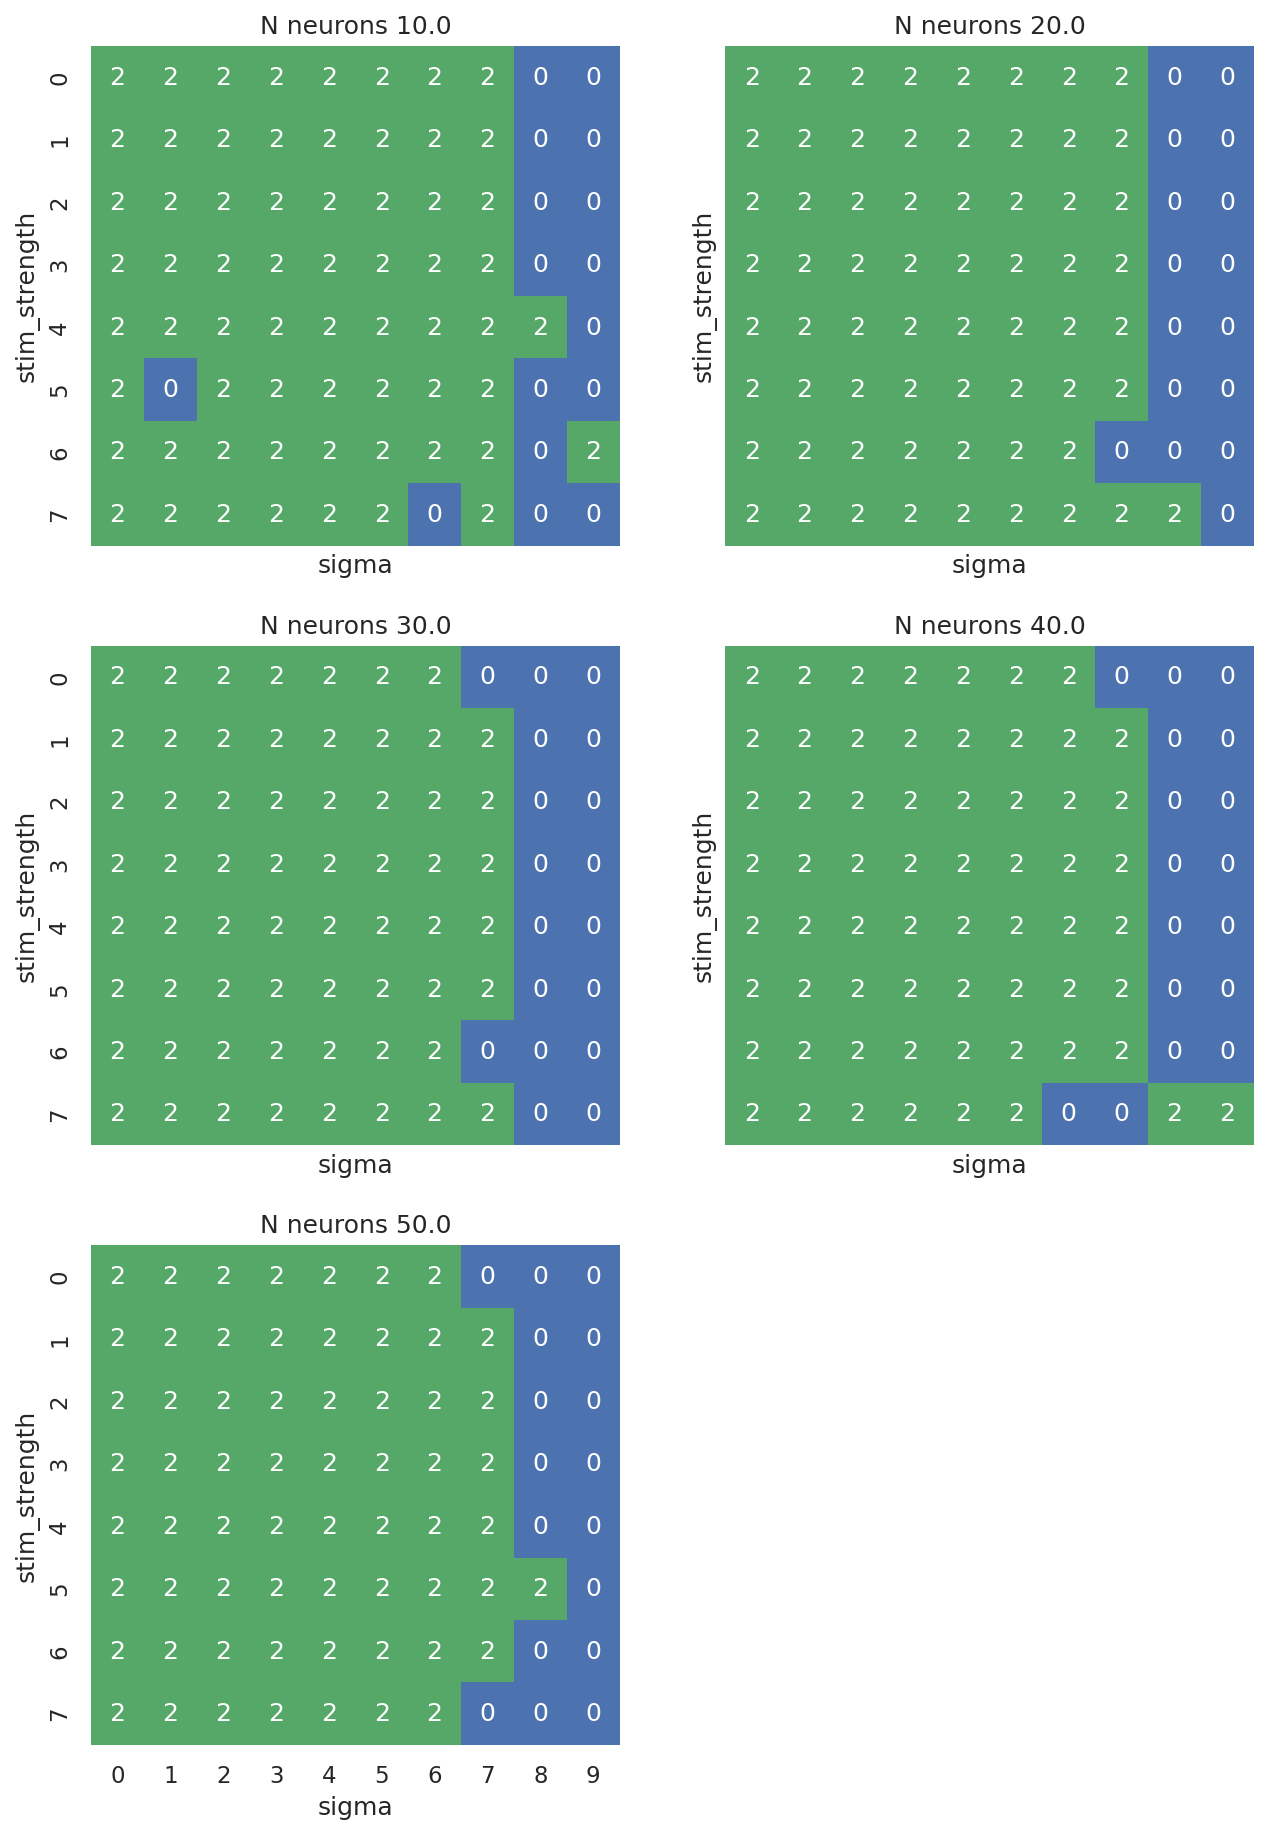

In [15]:
import matplotlib.gridspec as gridspec
fig, axs = plt.subplots(3, 2, figsize=(10,15), sharex=True, sharey=True)
axs = axs.ravel()
axs[-1].remove()
for i, (n_neurons, df) in enumerate(data_df.groupby('n_neurons')):
    ax = axs[i]
    min_error = np.concatenate(
    [df.pivot('sigma', 'stim_strength', 'error_beta_ols_did').values[:,:,None], 
     df.pivot('sigma', 'stim_strength', 'error_beta_iv_did').values[:,:,None], 
     df.pivot('sigma', 'stim_strength', 'error_beta_brew_did').values[:,:,None]], axis=2).argmin(2)
    sns.heatmap(
        min_error, 
        annot=min_error, 
        cmap=['C0', 'C1', 'C2'], vmin=0, vmax=2, ax=ax, cbar=False)
    ax.set_title(f'N neurons {n_neurons}')

    ax.set_xlabel('sigma')
    ax.set_ylabel('stim_strength')

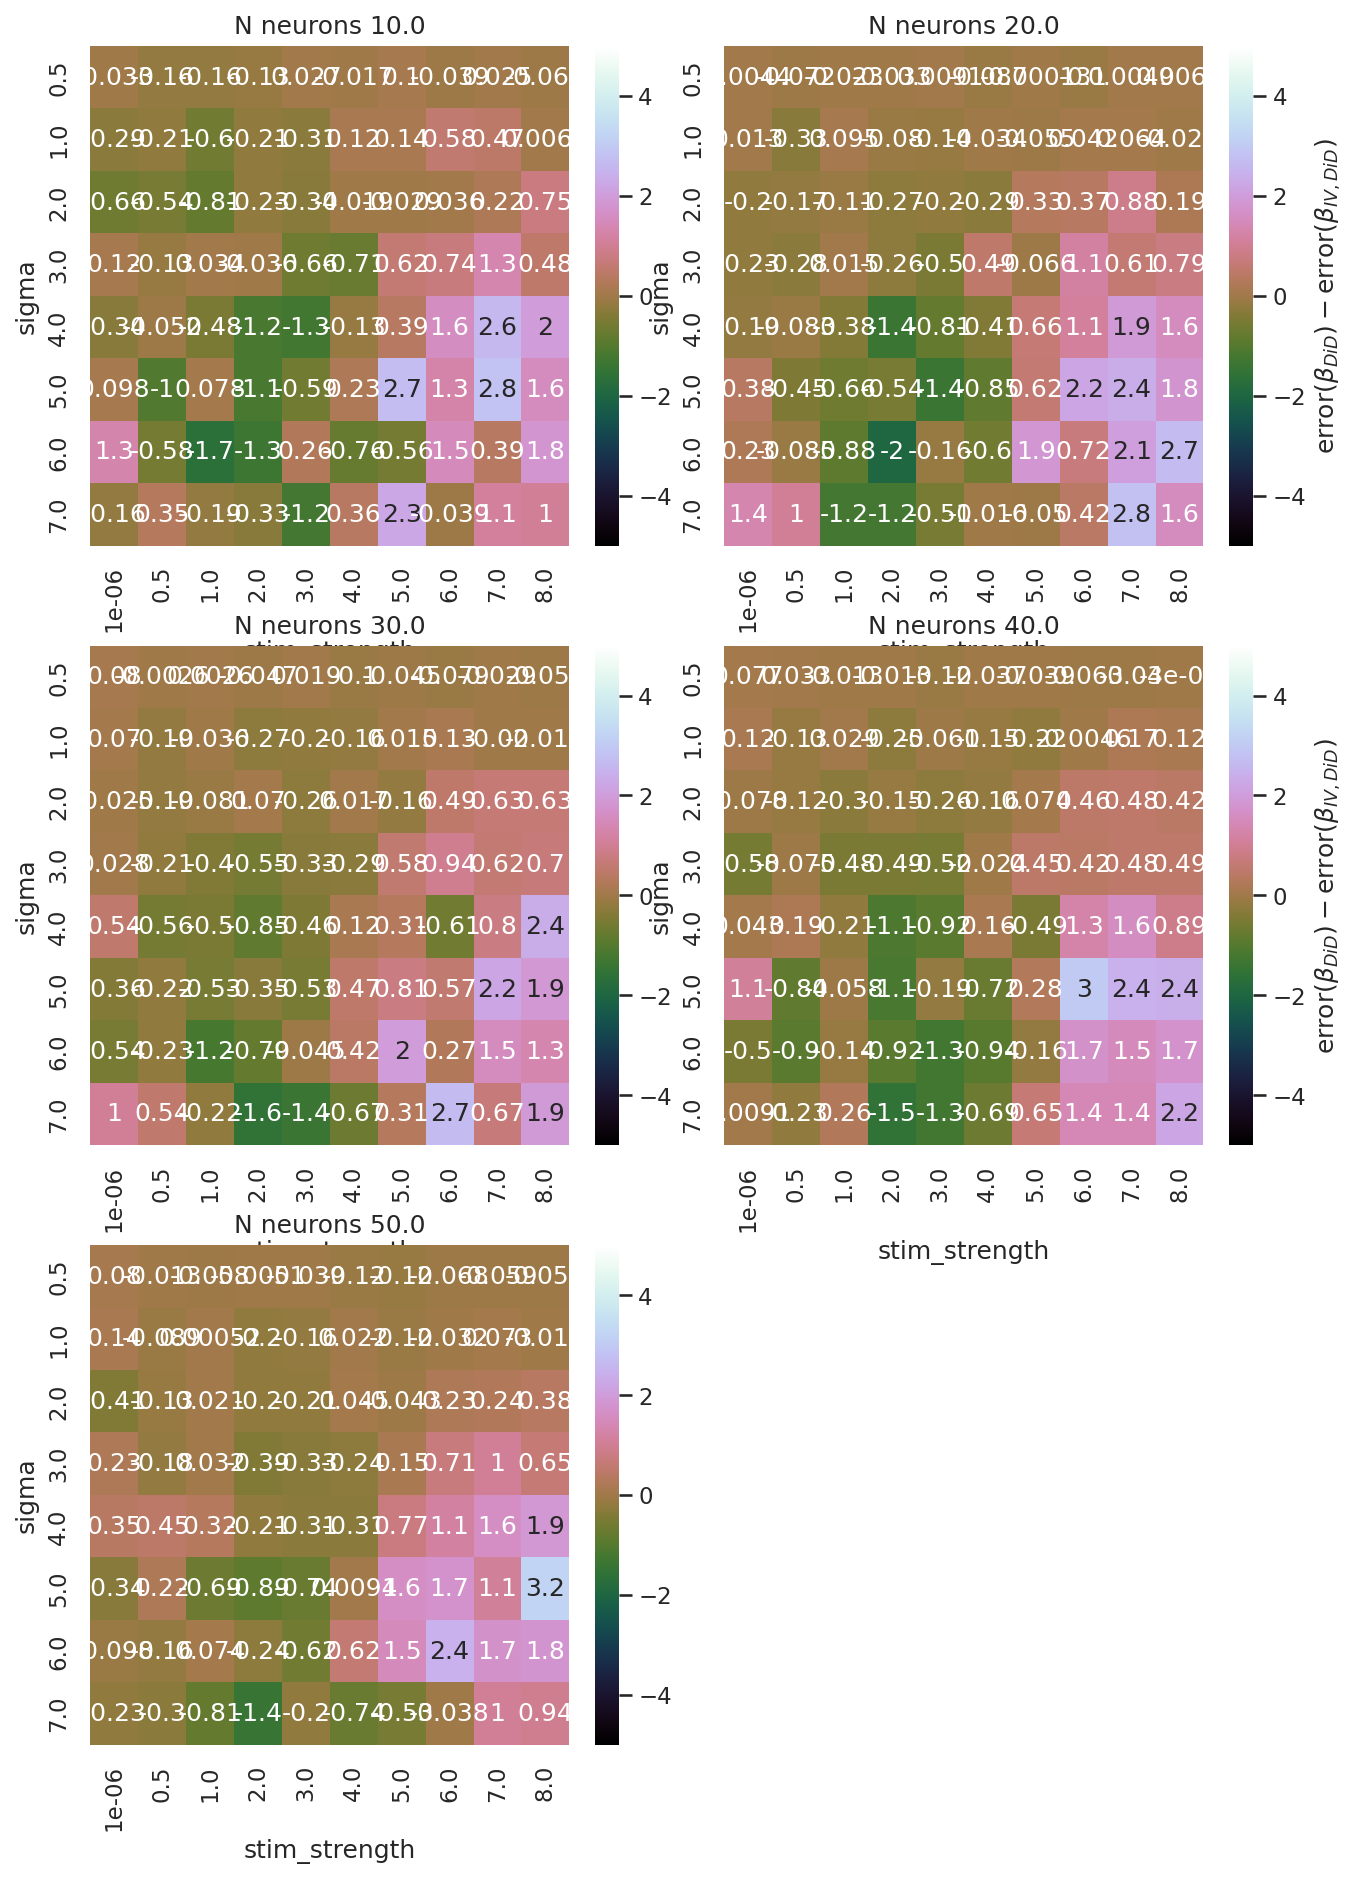

In [14]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,15))
gs = gridspec.GridSpec(3, 2, figure=fig)
for i, (n_neurons, df) in enumerate(data_df.groupby('n_neurons')):
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[i], width_ratios=[1,0.05], wspace=0.1)
    ax = fig.add_subplot(gs00[0,0])
    cax = fig.add_subplot(gs00[0,1])
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'error_diff_ols_iv_did'), 
        annot=df.pivot('sigma', 'stim_strength', 'error_diff_ols_iv_did'), 
        cmap='cubehelix', vmin=-5, vmax=5, cbar_ax=cax, ax=ax, 
        cbar_kws={'label': r'$\mathrm{error}(\beta_{DiD}) - \mathrm{error}(\beta_{IV,DiD})$' if i%2!=0 else ''})
    ax.set_title(f'N neurons {n_neurons}')

# Convergence

In [31]:
paths = [path for path in data_path.iterdir() if path.is_dir()]
n_samples = len(list(paths[0].glob('rank*.csv')))
observed_convergence_dict = {i: defaultdict(partial(np.empty, n_samples)) for i in data_df.index}
rng = np.random.default_rng()
pbar = tqdm(total=len(paths)*n_samples)
for i, row in data_df.iterrows():
    samples = [pd.read_csv(p) for p in pathlib.Path(row.path).glob('rank*.csv')]
    for ll in range(n_samples):
        sample = reduce_sum(samples[:ll+1])
        sample = pd.DataFrame([
            compute_connectivity_from_sum(row)
            for i, row in sample.iterrows()])
        observed_convergence_dict[i]['error_beta_ols_did'][ll] = min_error(sample, 'beta_ols_did').fun
        observed_convergence_dict[i]['error_beta_iv_did'][ll] = min_error(sample, 'beta_iv_did').fun
        observed_convergence_dict[i]['error_beta_brew_did'][ll] = min_error(sample, 'beta_brew_did').fun
        observed_convergence_dict[i]['error_beta_ols'][ll] = min_error(sample, 'beta_ols').fun
        observed_convergence_dict[i]['error_beta_iv'][ll] = min_error(sample, 'beta_iv').fun
        observed_convergence_dict[i]['error_beta_brew'][ll] = min_error(sample, 'beta_brew').fun
        observed_convergence_dict[i]['n_trials'][ll] = sample.n_trials.values[0]
        pbar.update(1)
pbar.close()

  0%|          | 0/44800 [00:00<?, ?it/s]

In [ ]:
grand_samples = {}
for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
    samples = [pd.read_csv(p) for p in pathlib.Path(row.path).glob('rank*.csv')]
    sample = reduce_sum(samples)
    grand_samples[i] = pd.DataFrame([
        compute_connectivity_from_sum(row)
        for i, row in sample.iterrows()])

In [63]:
index = data_df.query('n_neurons==10 and stim_strength==5 and sigma==6').iloc[0].name

In [64]:
index

315

In [65]:
data_df.loc[index, ['n_neurons', 'stim_strength', 'sigma']]

n_neurons        10.0
stim_strength     5.0
sigma             6.0
Name: 315, dtype: object

Text(0, 0.5, '$\\mathrm{error}(\\beta)$')

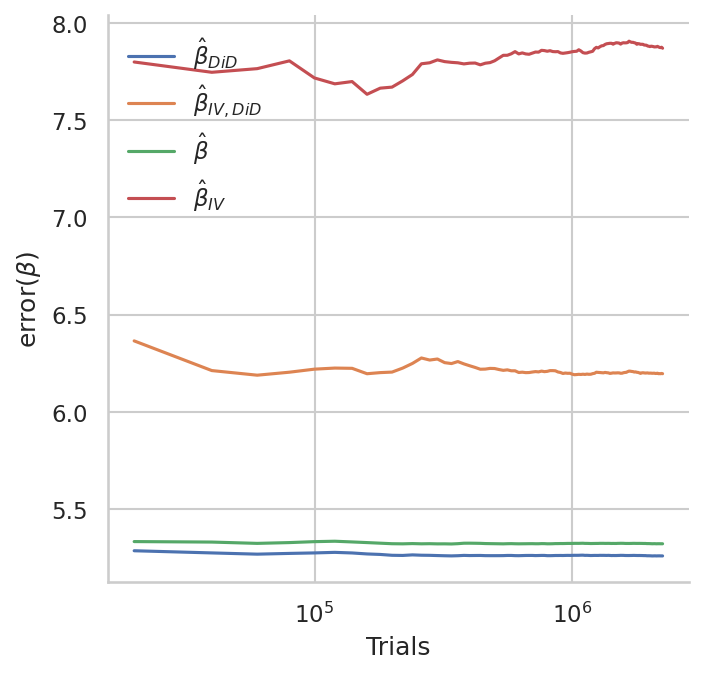

In [66]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
steps = observed_convergence_dict[index]['n_trials']
errors = observed_convergence_dict[index]

ax.plot(steps, errors['error_beta_ols_did'], label=r'$\hat{\beta}_{DiD}$')
ax.plot(steps, errors['error_beta_iv_did'], label=r'$\hat{\beta}_{IV,DiD}$')

ax.plot(steps, errors['error_beta_ols'], label=r'$\hat{\beta}$')
ax.plot(steps, errors['error_beta_iv'], label=r'$\hat{\beta}_{IV}$')

plt.legend(frameon=False)
ax.set_xscale('log')
sns.despine()
ax.set_xlabel('Trials')
ax.set_ylabel(r'$\mathrm{error}(\beta)$')

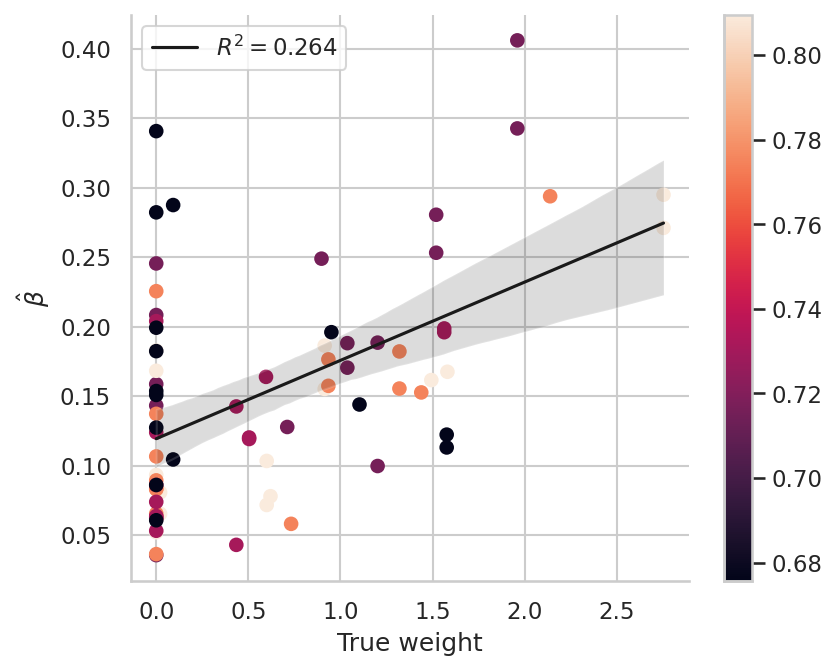

In [68]:
fig, ax = plt.subplots(1,1,figsize=(6,5), dpi=150)
model = regplot(
    'weight', 'beta_brew_did', data=grand_samples[index], 
    scatter_color=grand_samples[index]['hit_rate'], colorbar=True, ax=ax)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}$')
sns.despine()